In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import datetime, os

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Set up Dataset directory
dataset_dir = "dataset_ebs"


In [4]:
def get_subfolders(directory_path):
    """Return a list of subfolder names in the given directory."""
    subfolders = []
    # Check if the directory exists
    if os.path.exists(directory_path):
        # List all files and folders in the directory
        for item in os.listdir(directory_path):
            # Join the directory path with the item name
            full_path = os.path.join(directory_path, item)
            # Check if the item is a directory
            if os.path.isdir(full_path):
                subfolders.append(item)
    else:
        print("Directory does not exist.")
    return subfolders

class_names = get_subfolders(dataset_dir + '/_train')

print(class_names)

['goods', 'rejects']


In [5]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

# Let's make Prediction:

In [6]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);
    # print (f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    myPredict = ' '.join({class_names[target_image_pred_label]})
    myConf = target_image_pred_probs.detach().numpy().max()
    return myPredict, myConf

In [7]:
filename = "D:/vit_img_classif/dataset_ebs/20231208-161447_model.pth"
# Load the model weights 
loaded_weights = torch.load(filename)

# load the weights 
pretrained_vit.load_state_dict(loaded_weights)

<All keys matched successfully>

In [8]:
# Setup custom image path
custom_image_path = 'P2-034.jpg'

Class is goods  Confident is 0.9803438


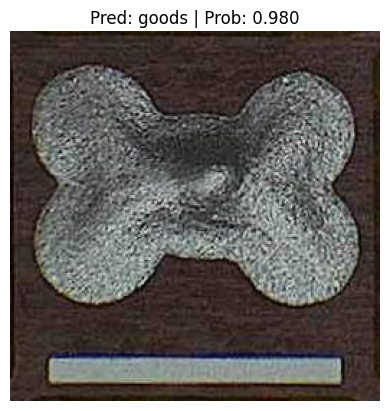

In [9]:
import requests

# Import function to make predictions on images and plot them 
# from going_modular.going_modular.predictions import pred_and_plot_image

# Predict on custom image
predict,conf = pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)
print ("Class is " + str(predict) + "  Confident is " + str(conf) )

In [10]:
type (conf)

numpy.float32

In [11]:
# Setup custom image path
custom_image_path = 'R-019.jpg'

Class is goods Confident is 0.9803438


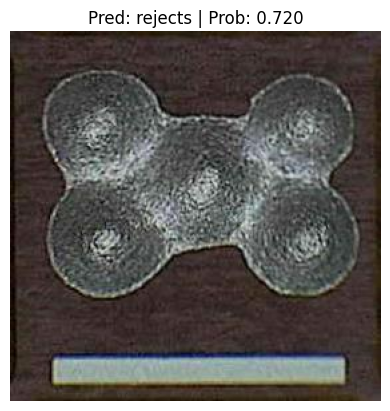

In [12]:
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)
print ("Class is " + str(predict) + " Confident is " + str(conf) )